## XGBoot


In [1]:
import os 
import sys
while os.path.split(os.getcwd())[1] != 'RecSysChallenge2023-Team':
    os.chdir('..')
sys.path.insert(1, os.getcwd())

In [2]:
path_save= "Daniele/Recommenders/XGBoot/saved_models"
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [3]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

import Daniele.Utils.MyDataManager as dm 
import Daniele.Utils.MatrixManipulation as mm
import Daniele.Utils.SaveSparceMatrix as ssm
import numpy as np 

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt=dm.getICMt()
ICMl=dm.getICMl()

name="train.csv"
dir = os.path.join(path_save,name)
if not os.path.exists(dir):
    URMv_train_val, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)
    URMv_train, URMv_validation = split_train_in_two_percentage_global_sample(URMv_train_val, train_percentage = 0.80)

    ssm.saveMatrix(dir,URMv_train)

    name="URMv_validation.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,URMv_validation)

    name="test.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,URMv_test)

    urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)
    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_def)

    urm_def_val = mm.defaultExplicitURM(urmv=URMv_train_val,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)
    name="urm_def_val.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_def_val)

    urm_bin = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo, normalize=False, add_aug=True)
    urm_bin.data = np.ones(len(urm_bin.data))
    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_bin)

    urm_bin_val = mm.defaultExplicitURM(urmv=URMv_train_val,urmo=URMo, normalize=False, add_aug=True)
    urm_bin_val.data = np.ones(len(urm_bin_val.data))
    name="urm_bin_val.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_bin_val)


else:
    URMv_train=ssm.readMatrix(dir)

    name="test.csv"
    dir = os.path.join(path_save,name)
    URMv_test=ssm.readMatrix(dir)

    name="URMv_validation.csv"
    dir = os.path.join(path_save,name)
    URMv_validation=ssm.readMatrix(dir)

    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    urm_def = ssm.readMatrix(dir)

    name="urm_def_val.csv"
    dir = os.path.join(path_save,name)
    urm_def_val = ssm.readMatrix(dir)

    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    urm_bin = ssm.readMatrix(dir)

    name="urm_bin_val.csv"
    dir = os.path.join(path_save,name)
    urm_bin_val = ssm.readMatrix(dir)


ICM =  mm.augmentedICM(dm.getICMt(),dm.getICMl())

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team


100%|██████████| 663370/663370 [00:00<00:00, 1723911.20it/s]


In [4]:
#Cambio di nomenclatura
URM_train = URMv_train
URM_test = URMv_test
URM_validation = URMv_validation

ICM_genres  = ICM

### Recommendations to use to train XGBoost


### RP3Beta

In [5]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
name="rp3beta"
dir = os.path.join(path_save,name)


rp3beta_recommender = RP3betaRecommender(urm_bin)
if not os.path.exists(dir+".zip"):
    rp3beta_recommender.fit(topK= 89, alpha= 0.6361002951626124, beta= 0.27432996564004203, normalize_similarity= True)
    rp3beta_recommender.save_model(path_save,name)
else:
    rp3beta_recommender.load_model(path_save,name)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 2925.64 column/sec. Elapsed time 9.56 sec
RP3betaRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsrp3beta'
RP3betaRecommender: Saving complete


## Build the dataframe with the predictions

Creating dataframes can be quite computationally expensive. Never use "append" or iteratively concatenate new elements when you have to run a significant number of iterations, it will take forever. Initialize instead the dimension you want.

In [6]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [7]:
#Hyper parameter !!!
cutoff = 40

for user_id in tqdm(range(n_users)):    
    recommendations = rp3beta_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")

100%|██████████| 41629/41629 [00:17<00:00, 2375.31it/s]


### We should add the target column, which is the correct recommendation as contained in the validation data

In [8]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,5068
1,0,10682
2,1,396
3,1,1180
4,1,19282
...,...,...
168287,41627,22186
168288,41628,767
168289,41628,5878
168290,41628,14567


In [9]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,20,left_only
1,0,23,left_only
2,0,2494,left_only
3,0,673,left_only
4,0,29,left_only
...,...,...,...
1665155,41628,3706,left_only
1665156,41628,8777,left_only
1665157,41628,6629,left_only
1665158,41628,6841,left_only


In [10]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,20,False
1,0,23,False
2,0,2494,False
3,0,673,False
4,0,29,False
...,...,...,...
1665155,41628,3706,False
1665156,41628,8777,False
1665157,41628,6629,False
1665158,41628,6841,False


## Now let's add some features. For example, the prediction of other algorithms

This may take some time so it is a good idea to save this data and load it instead of calculating the scores every time.

###  KNN_CFCBF

In [11]:
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom
name="knn_cfcbf"
dir = os.path.join(path_save,name)

KNN_recommender = KNN_CFCBF_custom(URMv_train,URMo,ICM_train=mm.augmentedICM(ICMt,ICMl))
if not os.path.exists(dir+".zip"):
    KNN_recommender.fit(topK= 744, shrink= 457, similarity= 'cosine', normalize= True, feature_weighting='TF-IDF')
    KNN_recommender.save_model(path_save,name)
else:
    KNN_recommender.load_model(path_save,name)

KNN_CFCBF_custom: URM Detected 3461 (12.4%) items with no interactions.
Beta-> 1.0 	ICM_weight-> 1.0
Similarity column 27968 (100.0%), 2829.37 column/sec. Elapsed time 9.88 sec
KNN_CFCBF_custom: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsknn_cfcbf'
KNN_CFCBF_custom: Saving complete


### RP3Beta - KNNCFCBF

In [12]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
alpha_knn_rp3 = 0.7
name="rp3beta-knn"
dir = os.path.join(path_save,name)


knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(urm_def)
if not os.path.exists(dir+".zip"):
    knn_rp3_recommender.fit((1 - alpha_knn_rp3) * KNN_recommender.W_sparse + alpha_knn_rp3* rp3beta_recommender.W_sparse)
    knn_rp3_recommender.save_model(path_save,name)
else:
    knn_rp3_recommender.load_model(path_save,name)

ItemKNNCustomSimilarityRecommender: URM Detected 2 ( 0.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsrp3beta-knn'
ItemKNNCustomSimilarityRecommender: Saving complete


### SSLIM- BPR
Ottimizzato per utenti con poche interazioni


In [13]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
name="sslim01"
dir = os.path.join(path_save,name)

sslim_recommender = SLIM_BPR_Cython(URM_train=urm_def)
if not os.path.exists(dir+".zip"):
    #{'topK': 51, 'epochs': 15, 'symmetric': True, 'sgd_mode': 'adam', 'lambda_i': 1e-05, 'lambda_j': 0.003215687724797301, 'learning_rate': 0.007114410195895492}
    sslim_recommender.fit(topK= 51, epochs=15,symmetric=True, sgd_mode = 'adam', lambda_i = 1e-05, lambda_j=0.003215687724797301, learning_rate = 0.007114410195895492)
    sslim_recommender.save_model(path_save,name)
else:
    sslim_recommender.load_model(path_save,name)

SLIM_BPR_Recommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.


/bin/sh: free: command not found


Processed 66219 (100.0%) in 2.95 sec. BPR loss is 1.07E+00. Sample per second: 22438
SLIM_BPR_Recommender: Epoch 1 of 15. Elapsed time 2.04 sec
Processed 66219 (100.0%) in 2.64 sec. BPR loss is 3.95E+00. Sample per second: 25055
SLIM_BPR_Recommender: Epoch 2 of 15. Elapsed time 3.73 sec
Processed 66219 (100.0%) in 2.92 sec. BPR loss is 6.81E+00. Sample per second: 22584
SLIM_BPR_Recommender: Epoch 3 of 15. Elapsed time 6.06 sec
Processed 66219 (100.0%) in 3.40 sec. BPR loss is 8.94E+00. Sample per second: 19449
SLIM_BPR_Recommender: Epoch 4 of 15. Elapsed time 8.51 sec
Processed 66219 (100.0%) in 2.01 sec. BPR loss is 1.13E+01. Sample per second: 32903
SLIM_BPR_Recommender: Epoch 5 of 15. Elapsed time 10.10 sec
Processed 66219 (100.0%) in 0.96 sec. BPR loss is 1.32E+01. Sample per second: 68950
SLIM_BPR_Recommender: Epoch 6 of 15. Elapsed time 11.05 sec
Processed 66219 (100.0%) in 1.33 sec. BPR loss is 1.66E+01. Sample per second: 49816
SLIM_BPR_Recommender: Epoch 7 of 15. Elapsed time

### TopPop

In [14]:
from Recommenders.NonPersonalizedRecommender import TopPop
name="TopPop"
dir = os.path.join(path_save,name)

most_viewed = TopPop(urm_bin)
if not os.path.exists(dir+".zip"):
    most_viewed.fit()
    most_viewed.save_model(path_save,name)
else:
    most_viewed.load_model(path_save,name)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.
TopPopRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsTopPop'
TopPopRecommender: Saving complete


In [15]:

other_algorithms = {
    "KNN_recommender": KNN_recommender,
    "knn_rp3_recommender": knn_rp3_recommender,
    "SLIM_BPR": sslim_recommender,
    "SLIM_BPR": sslim_recommender,
    "TopPop": most_viewed,
}


In [16]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(1000)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 1000/1000 [00:01<00:00, 587.18it/s]


,UserID,ItemID,Label,KNN_recommender,knn_rp3_recommender,SLIM_BPR,TopPop
0,0,20,False,9.312696,2.601918,65.639923,5950.0
1,0,23,False,8.295369,2.212981,50.253235,5174.0
2,0,2494,False,11.973664,3.829736,22.688799,1158.0
3,0,673,False,10.709507,3.456039,25.071556,1228.0
4,0,29,False,8.270042,2.204528,65.929932,4532.0
...,...,...,...,...,...,...,...
1665155,41628,3706,False,NaN,NaN,NaN,NaN
1665156,41628,8777,False,NaN,NaN,NaN,NaN
1665157,41628,6629,False,NaN,NaN,NaN,NaN
1665158,41628,6841,False,NaN,NaN,NaN,NaN


## Or the profile length URMv and URMo

In [17]:
n_views = np.ediff1d(sps.csr_matrix(URMv).indptr)
n_opens = np.ediff1d(sps.csr_matrix(URMo).indptr)

training_dataframe['n_views'] = n_views[training_dataframe["UserID"].values.astype(int)]
training_dataframe['n_opens'] = n_opens[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,KNN_recommender,knn_rp3_recommender,SLIM_BPR,TopPop,n_views,n_opens
0,0,20,False,9.312696,2.601918,65.639923,5950.0,12,58
1,0,23,False,8.295369,2.212981,50.253235,5174.0,12,58
2,0,2494,False,11.973664,3.829736,22.688799,1158.0,12,58
3,0,673,False,10.709507,3.456039,25.071556,1228.0,12,58
4,0,29,False,8.270042,2.204528,65.929932,4532.0,12,58
...,...,...,...,...,...,...,...,...,...
1665155,41628,3706,False,NaN,NaN,NaN,NaN,15,8
1665156,41628,8777,False,NaN,NaN,NaN,NaN,15,8
1665157,41628,6629,False,NaN,NaN,NaN,NaN,15,8
1665158,41628,6841,False,NaN,NaN,NaN,NaN,15,8


## The same can be done with item features

It is better in this case to first create a sparse matrix replicating the rows needed and ten transform it into a sparse dataframe

**WARNING** dataframes are not sparse structures and this may cause the memory requirements to explode

In [18]:
features_df = pd.DataFrame.sparse.from_spmatrix(ICM_genres)
features_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27963,1,0,0,0,0,0,0,0,1,0,0,0,0
27964,0,0,0,1,0,0,0,0,1,0,0,0,0
27965,1,0,0,0,0,0,0,0,1,0,0,0,0
27966,1,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

/Users/daniele/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,ItemID,UserID,Label,KNN_recommender,knn_rp3_recommender,SLIM_BPR,TopPop,n_views,n_opens,0,...,3,4,5,6,7,8,9,10,11,12
0,0,4521,False,NaN,NaN,NaN,NaN,10,7,1,...,0,0,0,0,0,1,0,0,0,0
1,0,6169,False,NaN,NaN,NaN,NaN,13,6,1,...,0,0,0,0,0,1,0,0,0,0
2,0,11172,False,NaN,NaN,NaN,NaN,15,10,1,...,0,0,0,0,0,1,0,0,0,0
3,0,11390,False,NaN,NaN,NaN,NaN,15,9,1,...,0,0,0,0,0,1,0,0,0,0
4,0,13483,False,NaN,NaN,NaN,NaN,12,9,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665155,24506,11213,False,NaN,NaN,NaN,NaN,29,9,1,...,0,0,0,0,0,1,0,0,0,0
1665156,24506,24447,False,NaN,NaN,NaN,NaN,12,4,1,...,0,0,0,0,0,1,0,0,0,0
1665157,24506,29693,False,NaN,NaN,NaN,NaN,20,16,1,...,0,0,0,0,0,1,0,0,0,0
1665158,24506,35449,False,NaN,NaN,NaN,NaN,11,7,1,...,0,0,0,0,0,1,0,0,0,0


## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [20]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,ItemID,UserID,Label,KNN_recommender,knn_rp3_recommender,SLIM_BPR,TopPop,n_views,n_opens,0,...,3,4,5,6,7,8,9,10,11,12
0,14710,0,False,9.966388,3.184969,29.595318,669.0,12,58,0,...,0,0,0,0,1,0,0,1,0,0
1,299,0,False,9.425893,2.959155,17.508018,319.0,12,58,1,...,0,0,0,0,1,0,1,0,0,0
2,25,0,False,7.462696,2.006235,43.204468,4812.0,12,58,0,...,0,0,0,0,0,1,0,0,0,0
3,282,0,False,8.483869,2.652981,20.628258,672.0,12,58,0,...,0,0,0,0,0,1,0,0,0,0
4,20768,0,False,9.078197,2.798583,13.071829,300.0,12,58,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665155,22,41628,False,NaN,NaN,NaN,NaN,15,8,0,...,1,0,0,0,0,1,0,0,0,0
1665156,23976,41628,False,NaN,NaN,NaN,NaN,15,8,0,...,1,0,0,0,1,0,0,1,0,0
1665157,563,41628,False,NaN,NaN,NaN,NaN,15,8,0,...,0,0,0,0,0,1,0,0,0,0
1665158,769,41628,False,NaN,NaN,NaN,NaN,15,8,0,...,0,0,0,0,0,1,0,0,0,0


### To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user (30) all groups have the same length.

In [21]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([40, 40, 40, ..., 40, 40, 40])

In [22]:
from xgboost import XGBRanker

In [23]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [24]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=False, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

### Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.

### Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [25]:
XGB_model.predict(X_train)

array([-0.01377564,  0.43806818,  0.44905892, ...,  0.7538658 ,
        0.78387016,  0.61192137], dtype=float32)

### We can have a look to the feature importance to assess which are the most informative ones

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

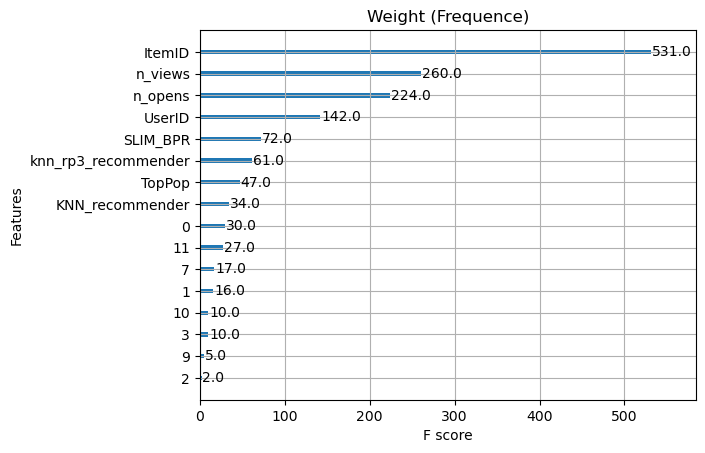

In [27]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem. 

How to address this? 
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

### How to perform hyperparameter tuning?
The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.

In [32]:
from sklearn.metrics import precision_score
import xgboost as xgb

preds = XGB_model.predict(X_train)
"""
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(, best_preds, average='macro')))
"""
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender()
ris

EvaluatorHoldout: Ignoring 1516 ( 3.6%) Users that have less than 1 test interactions


AttributeError: 'XGBRanker' object has no attribute 'get_URM_train'